<a href="https://colab.research.google.com/github/nlp-en-es/nlp-de-cero-a-cien/blob/main/6_demos/fine_tune_Spanish_RoBERTa_BSC_for_QA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune Spanish RoBERTa (BSC) for QA on SQAC / by [mrm8488](https://twitter.com/mrm8488)

> Based on Sylvain Gugger [Colab](https://github.com/huggingface/notebooks/blob/master/examples/question_answering.ipynb)

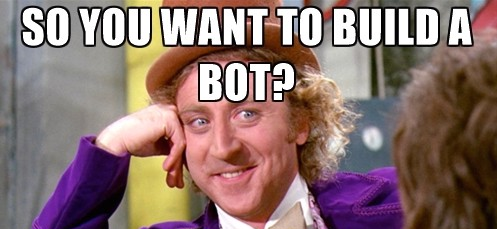

In [ ]:
!nvidia-smi

Tue Oct  5 10:42:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    41W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# ! pip3 install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
%%capture
! pip install datasets transformers

Si está abriendo este cuaderno localmente, asegúrese de que su entorno tenga una instalación de la última versión de esas bibliotecas.

Para poder compartir su modelo con la comunidad y generar resultados como el que se muestra en la imagen a continuación a través de la API de inferencia, hay algunos pasos más a seguir.

Primero debe almacenar su token de autenticación del sitio web Hugging Face (regístrese [aquí](https://huggingface.co/join) si aún no lo ha hecho). Luego ejecute la siguiente celda e ingrese su nombre de usuario y contraseña:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Necesitamos instalar Git-LFS. Descomenta y ejecuta la siguiente celda

In [ ]:
! apt install git-lfs

Asegúrese de que su versión de Transformers sea al menos 4.11.0 ya que la funcionalidad se introdujo en esa versión:

In [ ]:
import transformers

print(transformers.__version__)

4.11.2


You can find a script version of this notebook to fine-tune your model in a distributed fashion using multiple GPUs or TPUs [here](https://github.com/huggingface/transformers/tree/master/examples/question-answering).

# Fine-tuning de un modelo para la tarea de QA

En este cuaderno, veremos cómo hacer "fine-tuning" a uno de los modelos de [🤗 Transformers](https://github.com/huggingface/transformers) para la tarea de respuesta a una pregunta (QA), que es la tarea de extraer la respuesta a una pregunta de un contexto dado. Veremos cómo cargar fácilmente un conjunto de datos para este tipo de tareas y usar la API `Trainer` para ajustar un modelo en él.

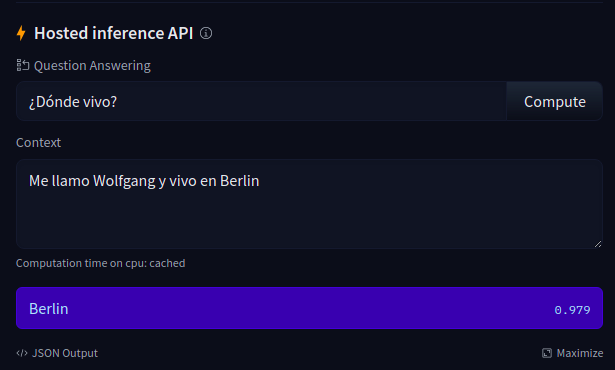

** Nota: ** Este cuaderno afina los modelos que responden preguntas tomando una subcadena de un contexto, no generando texto nuevo.

In [ ]:
squad_v2 = False
model_checkpoint = "BSC-TeMU/roberta-base-bne"
batch_size = 16

## Cargando el dataset

Usaremos la biblioteca [🤗 Datasets](https://github.com/huggingface/datasets) para descargar los datos y obtener la métrica que necesitamos usar para la evaluación (para comparar nuestro modelo con el benchmark). Esto se puede hacer fácilmente con las funciones `load_dataset` y` load_metric`.

In [ ]:
from datasets import load_dataset, load_metric

Para nuestro ejemplo usaremos el [Dataset SQAC](https://huggingface.co/datasets/BSC-TeMU/SQAC). El cuaderno debe funcionar con cualquier conjunto de datos de respuesta a preguntas proporcionado por la biblioteca 🤗 Datasets. Si está utilizando su propio conjunto de datos definido a partir de un archivo JSON o csv (consulte la [documentación de Datasets[texto del enlace](https://)](https://huggingface.co/docs/datasets/loading_datasets.html#from-local-files) sobre cómo cargarlos ), es posible que necesite algunos ajustes en los nombres de las columnas utilizadas.

In [ ]:
datasets = load_dataset("BSC-TeMU/SQAC")

Downloading:   0%|          | 0.00/5.56k [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/11.0M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset sqac downloaded and prepared to /root/.cache/huggingface/datasets/sqac/SQAC/0.0.0/78b497aeaab849ca7bf2768217c8bddc8909556fc0b06d365a6b64d065f42419. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

The `datasets` object itself is [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, validation and test set.

In [ ]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 15036
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1864
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1910
    })
})

In [ ]:
datasets["train"][0]

{'answers': {'answer_start': [473], 'text': ['la de origen occidental']},
 'context': 'La historia de Japón (日本の歴史 o 日本史, Nihon no rekishi / Nihonshi?) es la sucesión de hechos acontecidos dentro del archipiélago japonés. Algunos de estos hechos aparecen aislados e influenciados por la naturaleza geográfica de Japón como nación insular, en tanto que otra serie de hechos, obedece a influencias foráneas como en el caso del Imperio chino, el cual definió su idioma, su escritura y, también, su cultura política. Asimismo, otra de las influencias foráneas fue la de origen occidental, lo que convirtió al país en una nación industrial, ejerciendo con ello una esfera de influencia y una expansión territorial sobre el área del Pacífico. No obstante, dicho expansionismo se detuvo tras la Segunda Guerra Mundial y el país se posicionó en un esquema de nación industrial con vínculos a su tradición cultural.',
 'id': '6cf3dcd6-b5a3-4516-8f9e-c5c1c6b66628',
 'question': '¿Qué influencia convirtió Japó

Podemos ver que las respuestas están indicadas por su posición inicial en el texto (aquí en el carácter 473) y su texto completo, que es una subcadena del contexto como mencionamos anteriormente.

In [ ]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "No puedes seleccionar más elementos que los que contiene el dataset"
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(datasets["train"])

,id,title,context,question,answers
0,bbacb0c8-3a87-4071-b8ad-c8fedd7bb1c5,Asteroide troyano,"Origen y evolución \nExisten dos teorías principales respecto a los troyanos. Una de ellas sugiere que los troyanos se formaron en la misma región del sistema solar que Júpiter y se incorporaron a su órbita cuando el planeta todavía se encontraba en formación. La última etapa de la formación de Júpiter involucró un crecimiento descontrolado de su masa debido a la acreción de grandes cantidades de hidrógeno y helio del disco protoplanetario; durante este crecimiento, el cual se prolongó solamente unos 10 000 años, la masa de Júpiter se multiplicó por diez. Los planetesimales que tenían órbitas cercanas a las de Júpiter fueron capturados por el campo gravitatorio cada vez más intenso del planeta gigante. El mecanismo de captura era muy eficiente, ya que según la teoría fueron atrapados alrededor del 50 % de los planetesimales restantes. Sin embargo, esta hipótesis presenta dos problemas de capital importancia: el número de cuerpos atrapados excede en cuatro órdenes de magnitud la población de troyanos observada, y los asteroides troyanos actuales poseen inclinaciones orbitales mayores que las predichas por el modelo. No obstante, las simulaciones realizadas sobre este escenario muestran que este modo de formación inhibiría la creación de troyanos similares alrededor de Saturno, lo cual concuerda perfectamente con las observaciones.",¿Cuál fue el aumento que experimentó la masa de Júpiter durante la última fase de su formación?,"{'text': ['se multiplicó por diez'], 'answer_start': [537]}"
1,108c073e-29ce-443f-b96d-6126371e2404,"Un sismo de 7,9 grados sacude el norte de Chile","14 de junio de 2005 14 de junio de 2005Iquique, Chile — Un fuerte sismo de 7,9 grados en la escala de Richter se registró la tarde del lunes al norte de Chile. El movimiento telúrico tuvo su epicentro a 115 km al nordeste de la ciudad de Iquique, cerca de la frontera con Bolivia, y ocurrió a las 18:45 hora local (22:45 UTC) del lunes. Hasta el momento (16:45 UTC) han fallecido 11 personas, identificadas por las autoridades chilenas como Dionisio Pérez, Adela Castro, Sergio Véliz, Nilda Luisa Cantillana Lazo, José Esteban González Francino, Enrique Segundo González Francino, Sidcrif Orlanda Flores Cantillana, Alan Moisés Brain Flores, Ignacio Bravo Flores, Abraham Vásquez (de 9 meses de edad) y Petronila Mamani. Apenas ocurrió el sismo, fueron evacuadas las escuelas, el pánico se generalizó y se presentaron cortes de energía eléctrica. El movimiento, el de mayor intensidad tras el del Océano Índico del pasado 26 de diciembre, también se pudo sentir al sur de Perú y de Bolivia, pero no se tienen datos acerca de víctimas o daños en esos países. Un muy pequeño sismo fue sentido en algunas ciudades en Brasil, sin haber, aparentemente daños o víctimas. El subsecretario del Interior chileno, Jorge Correa Sutil, declaró que ""el gobierno ha decretado alerta roja en toda la toda la región de Tarapacá, por lo que se suspenden las clases, viajará un avión con equipos para poder habilitar albergues de emergencia, principalmente, en la zona interior de Iquique, la más afectada"". A pesar de la intensidad del temblor, no se declaró en ningún momento alerta de tsunami.","¿Dónde tuvo lugar el terremoto de 7,9 grados del lunes por la tarde?","{'text': ['Chile'], 'answer_start': [153]}"
2,4c19d6c2-ff8a-4ce0-aa87-bd7a42393539,Laika,"Laika (en ruso Лайка, ‘ladradora’; Moscú, Unión Soviética, 1954 - Sputnik 2, Órbita baja terrestre, 3 de noviembre de 1957) fue una perra espacial soviética que se convirtió en el primer ser vivo terrestre en orbitar la Tierra. Lo hizo a bordo de la nave soviética Sputnik 2, el 3 de noviembre de 1957, un mes después que el satélite Sputnik 1. También fue el primer animal que murió en órbita.",¿En qué cohete fue enviada Laika a orbitar la Tierra?,"{'text': ['la nave soviética Sputnik 2'], 'answer_start': [247]}"
3,1350cf77-26f8-42cf-a5fc-09f0587c2397,Kim Jo

## Preprocessing the training data

In [ ]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/613 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/497k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [ ]:
tokenizer("What is your name?", "My name is Sylvain.")

{'input_ids': [0, 109, 8366, 4100, 49076, 356, 4680, 85, 2, 2, 23803, 356, 4680, 4100, 415, 12031, 1315, 340, 68, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Dependiendo del modelo que seleccionó, verá diferentes claves en el diccionario devueltas por la celda de arriba. No importan mucho para lo que estamos haciendo aquí (solo sepa que son requeridos por el modelo que crearemos más adelante), puede obtener más información sobre ellos en [este tutorial](https://huggingface.co/transformers/preprocessing.html) si está interesado.

Ahora bien, una cosa específica para el preprocesamiento en cuestión es cómo tratar documentos muy largos. Por lo general, los truncamos en otras tareas, cuando son más largos que la longitud máxima de oración del modelo, pero aquí, eliminar parte del contexto puede resultar en la pérdida de la respuesta que estamos buscando. Para lidiar con esto, permitiremos que un ejemplo (largo) en nuestro conjunto de datos proporcione varias características de entrada, cada una de una longitud más corta que la longitud máxima del modelo (o la que establecemos como un hiperparámetro). Además, en caso de que la respuesta esté en el punto en que dividimos un contexto largo, permitimos cierta superposición entre las características que generamos controladas por el hiperparámetro `doc_stride`:

In [ ]:
max_length = 384 # The maximum length of a feature (question and context)
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.

Encontremos el ejemplo más largo en nuestro dataset:

In [ ]:
for i, example in enumerate(datasets["train"]):
    if len(tokenizer(example["question"], example["context"])["input_ids"]) > 384:
        break
example = datasets["train"][i]

Sin truncar obtenemos la siguiente longitud de los input IDs:

In [ ]:
len(tokenizer(example["question"], example["context"])["input_ids"])

484

Ahora, truncamos (y perdemos información):

In [ ]:
len(tokenizer(example["question"], example["context"], max_length=max_length, truncation="only_second")["input_ids"])

384

Tenga en cuenta que nunca queremos truncar la pregunta, solo el contexto, por eso usamos el truncamiento `only_second`. Ahora, nuestro tokenizador puede devolvernos automáticamente una lista de características con un límite de cierta longitud máxima, con la superposición que hablamos 

In [ ]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    stride=doc_stride
)

Ahora no tenemos una lista de `input_ids`, sino varias: 

In [ ]:
[len(x) for x in tokenized_example["input_ids"]]

[384, 240]

Y si los decodificamos, podemos ver la superposición:

In [ ]:
for x in tokenized_example["input_ids"][:2]:
    print(tokenizer.decode(x))

<s>¿Qué premio ganó Margarita Fullana?</s></s>La española Margarita Fullana logró hoy, sábado, la medalla de bronce en la prueba de "mountain-bike" o bicicleta todo terreno (BTT) de los Juegos de Sydney, en una jornada en la que la italiana Paola Pezzo, ganadora en Atlanta, revalidó su título olímpico, el único que se había disputado hasta la fecha. Fullana entró en meta a 33 segundos de la campeona italiana, que cubrió los 35,7 kilómetros del recorrido olímpico en un tiempo de una hora, 49 minutos y 24 segundos, con una ventaja de 27 segundos sobre Barbara Blatter, que regresará a Suiza con una medalla de plata. La mallorquina, de 28 años, doble campeona del mundo de la especialidad (1999 y 2000), aspiraba al oro, pero la falta de un mayor desnivel en el circuito y una caída que sufrió en la cuarta vuelta tras chocar con Pezzo en un rocoso descenso la obligaron a conformarse con un bronce olímpico que, en cualquiera de los casos, pone broche a una sensacional temporada. Fullana se sit

Ahora, esto nos dará algo de trabajo para tratar adecuadamente las respuestas: necesitamos encontrar en cuál de esas características se encuentra realmente la respuesta y dónde exactamente en esa característica. Los modelos que usaremos requieren las posiciones inicial y final de estas respuestas en los tokens, por lo que también necesitaremos mapear partes del contexto original a algunos tokens. Afortunadamente, el tokenizador que estamos usando puede ayudarnos con eso devolviendo un `offset_mapping`:

In [ ]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    stride=doc_stride
)
print(tokenized_example["offset_mapping"][0][:100])

[(0, 0), (0, 1), (1, 4), (5, 11), (12, 16), (17, 26), (27, 31), (31, 34), (34, 35), (0, 0), (0, 0), (0, 2), (3, 11), (12, 21), (22, 26), (26, 29), (30, 35), (36, 39), (39, 40), (41, 47), (47, 48), (49, 51), (52, 59), (60, 62), (63, 69), (70, 72), (73, 75), (76, 82), (83, 85), (86, 87), (87, 89), (89, 95), (95, 96), (96, 98), (98, 100), (100, 101), (102, 103), (104, 113), (114, 118), (119, 126), (127, 128), (128, 129), (129, 131), (131, 132), (133, 135), (136, 139), (140, 146), (147, 149), (150, 151), (151, 153), (153, 156), (156, 157), (158, 160), (161, 164), (165, 172), (173, 175), (176, 178), (179, 182), (183, 185), (186, 194), (195, 197), (197, 200), (201, 202), (202, 204), (204, 206), (206, 207), (208, 216), (217, 219), (220, 227), (227, 228), (229, 234), (234, 237), (238, 240), (241, 247), (248, 256), (256, 257), (258, 260), (261, 266), (267, 270), (271, 273), (274, 279), (280, 289), (290, 295), (296, 298), (299, 304), (304, 305), (306, 310), (310, 313), (314, 319), (320, 322), (3

Esto da, para cada índice de nuestro IDS de entrada, el carácter inicial y final correspondiente en el texto original que dio nuestro token. El primer token (`[CLS]`) tiene (0, 0) porque no corresponde a ninguna parte de la pregunta / respuesta, entonces el segundo token es el mismo que los caracteres 0 a 3 de la pregunta:

In [ ]:
first_token_id = tokenized_example["input_ids"][0][1]
offsets = tokenized_example["offset_mapping"][0][1]
print(tokenizer.convert_ids_to_tokens([first_token_id])[0], example["question"][offsets[0]:offsets[1]])

Â¿ ¿


Entonces, podemos usar este mapeo para encontrar la posición de los tokens de inicio y finalización de nuestra respuesta en una característica determinada. Solo tenemos que distinguir qué partes de las compensaciones corresponden a la pregunta y qué parte corresponden al contexto, aquí es donde el método `sequence_ids` de nuestro` tokenized_example` puede ser útil:

In [ ]:
sequence_ids = tokenized_example.sequence_ids()
print(sequence_ids)

[None, 0, 0, 0, 0, 0, 0, 0, 0, None, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 


Devuelve `None` para los tokens especiales, luego 0 o 1 dependiendo de si el token correspondiente proviene de la primera oración pasada (la pregunta) o de la segunda (el contexto). Ahora, con todo esto, podemos encontrar el primer y último token de la respuesta en una de nuestras funciones de entrada (o si la respuesta no está en esta función):

In [ ]:
answers = example["answers"]
start_char = answers["answer_start"][0]
end_char = start_char + len(answers["text"][0])

# Start token index of the current span in the text.
token_start_index = 0
while sequence_ids[token_start_index] != 1:
    token_start_index += 1

# End token index of the current span in the text.
token_end_index = len(tokenized_example["input_ids"][0]) - 1
while sequence_ids[token_end_index] != 1:
    token_end_index -= 1

# Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
offsets = tokenized_example["offset_mapping"][0]
if (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
    # Move the token_start_index and token_end_index to the two ends of the answer.
    # Note: we could go after the last offset if the answer is the last word (edge case).
    while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
        token_start_index += 1
    start_position = token_start_index - 1
    while offsets[token_end_index][1] >= end_char:
        token_end_index -= 1
    end_position = token_end_index + 1
    print(start_position, end_position)
else:
    print("The answer is not in this feature.")

21 24


Y podemos comprobar que es la respuesta correcta:

In [ ]:
print(tokenizer.decode(tokenized_example["input_ids"][0][start_position: end_position+1]))
print(answers["text"][0])

 la medalla de bronce
la medalla de bronce


Para que este cuaderno funcione con cualquier tipo de modelo, debemos tener en cuenta el caso especial en el que el modelo espera relleno a la izquierda (en cuyo caso cambiamos el orden de la pregunta y el contexto):

In [ ]:
pad_on_right = tokenizer.padding_side == "right"

Ahora juntemos todo en una función que aplicaremos a nuestro conjunto de entrenamiento. En el caso de respuestas imposibles (la respuesta está en otra característica dada por un ejemplo con un contexto largo), establecemos el índice cls tanto para la posición inicial como para la final. También podríamos simplemente descartar esos ejemplos del conjunto de entrenamiento si la marca `allow_impossible_answers` es` False`. Dado que el preprocesamiento ya es lo suficientemente complejo como es, hemos mantenido que es simple para esta parte.

In [ ]:
def prepare_train_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [ ]:
features = prepare_train_features(datasets['train'][:5])

In [ ]:
tokenized_datasets = datasets.map(prepare_train_features, batched=True, remove_columns=datasets["train"].column_names)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

## Fine-tuning del modelo

In [ ]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

Some weights of the model checkpoint at BSC-TeMU/roberta-base-bne were not used when initializing RobertaForQuestionAnswering: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at BSC-TeMU/roberta-base-bne and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN t

In [ ]:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-sqac",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=True,
)

Luego, necesitaremos un `data_collator` que agrupe nuestros ejemplos procesados, aquí el predeterminado funcionará:

In [ ]:
from transformers import default_data_collator

data_collator = default_data_collator

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

Cloning https://huggingface.co/mrm8488/roberta-base-bne-finetuned-sqac into local empty directory.


In [ ]:
trainer.train()

***** Running training *****
  Num examples = 19126
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3588


Epoch,Training Loss,Validation Loss
1,0.997100,0.864572
2,0.482000,0.933443
3,0.165200,1.211125


Saving model checkpoint to roberta-base-bne-finetuned-sqac/checkpoint-500
Configuration saved in roberta-base-bne-finetuned-sqac/checkpoint-500/config.json
Model weights saved in roberta-base-bne-finetuned-sqac/checkpoint-500/pytorch_model.bin
tokenizer config file saved in roberta-base-bne-finetuned-sqac/checkpoint-500/tokenizer_config.json
Special tokens file saved in roberta-base-bne-finetuned-sqac/checkpoint-500/special_tokens_map.json
tokenizer config file saved in roberta-base-bne-finetuned-sqac/tokenizer_config.json
Special tokens file saved in roberta-base-bne-finetuned-sqac/special_tokens_map.json
Saving model checkpoint to roberta-base-bne-finetuned-sqac/checkpoint-1000
Configuration saved in roberta-base-bne-finetuned-sqac/checkpoint-1000/config.json
Model weights saved in roberta-base-bne-finetuned-sqac/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in roberta-base-bne-finetuned-sqac/checkpoint-1000/tokenizer_config.json
Special tokens file saved in roberta-b

TrainOutput(global_step=3588, training_loss=0.6607079790321614, metrics={'train_runtime': 473.327, 'train_samples_per_second': 121.223, 'train_steps_per_second': 7.58, 'total_flos': 1.1244513980998656e+16, 'train_loss': 0.6607079790321614, 'epoch': 3.0})

Como el entrenamiento es largo, guardemos el modelo por si necesitamos reiniciar el entrenamiento

In [ ]:
trainer.save_model("test-squad-trained")

Saving model checkpoint to test-squad-trained
Configuration saved in test-squad-trained/config.json
Model weights saved in test-squad-trained/pytorch_model.bin
tokenizer config file saved in test-squad-trained/tokenizer_config.json
Special tokens file saved in test-squad-trained/special_tokens_map.json


## Evaluación

In [ ]:
def prepare_validation_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

And like before, we can apply that function to our validation set easily:

In [ ]:
validation_features = datasets["test"].map(
    prepare_validation_features,
    batched=True,
    remove_columns=datasets["test"].column_names
)

  0%|          | 0/2 [00:00<?, ?ba/s]

Now we can grab the predictions for all features by using the `Trainer.predict` method:

In [ ]:
raw_predictions = trainer.predict(validation_features)

The following columns in the test set  don't have a corresponding argument in `RobertaForQuestionAnswering.forward` and have been ignored: example_id, offset_mapping.
***** Running Prediction *****
  Num examples = 2309
  Batch size = 16


In [ ]:
validation_features.set_format(type=validation_features.format["type"], columns=list(validation_features.features.keys()))

In [ ]:
max_answer_length = 30

In [ ]:
start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
offset_mapping = validation_features[0]["offset_mapping"]
# The first feature comes from the first example. For the more general case, we will need to be match the example_id to
# an example index
context = datasets["validation"][0]["context"]

# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
        # to part of the input_ids that are not in the context.
        if (
            start_index >= len(offset_mapping)
            or end_index >= len(offset_mapping)
            or offset_mapping[start_index] is None
            or offset_mapping[end_index] is None
        ):
            continue
        # Don't consider answers with a length that is either < 0 or > max_answer_length.
        if end_index < start_index or end_index - start_index + 1 > max_answer_length:
            continue
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            start_char = offset_mapping[start_index][0]
            end_char = offset_mapping[end_index][1]
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": context[start_char: end_char]
                }
            )

valid_answers = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[:n_best_size]
valid_answers

In [ ]:
datasets["test"][0]["answers"]

{'answer_start': [3], 'text': ['célula']}

In [ ]:
import collections

examples = datasets["test"]
features = validation_features

example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
features_per_example = collections.defaultdict(list)
for i, feature in enumerate(features):
    features_per_example[example_id_to_index[feature["example_id"]]].append(i)

In [ ]:
from tqdm.auto import tqdm

def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = 20, max_answer_length = 30):
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None # Only used if squad_v2 is True.
        valid_answers = []
        
        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}
        
        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        if not squad_v2:
            predictions[example["id"]] = best_answer["text"]
        else:
            answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
            predictions[example["id"]] = answer

    return predictions

And we can apply our post-processing function to our raw predictions:

In [ ]:
final_predictions = postprocess_qa_predictions(datasets["test"], validation_features, raw_predictions.predictions)

Post-processing 1910 example predictions split into 2309 features.


  0%|          | 0/1910 [00:00<?, ?it/s]

Then we can load the metric from the datasets library.

In [ ]:
metric = load_metric("squad")

Downloading:   0%|          | 0.00/1.73k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

In [ ]:
formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
references = [{"id": ex["id"], "answers": ex["answers"]} for ex in datasets["test"]]
metric.compute(predictions=formatted_predictions, references=references)

{'exact_match': 60.05235602094241, 'f1': 79.03119235190982}

Ahora puede cargar el resultado del entrenamiento en el Hub, simplemente ejecute esta instrucción:

In [ ]:
trainer.push_to_hub()